In [1]:
# imports
from transformers import pipeline
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from os import listdir
from os.path import isfile, join

In [3]:
nltk.download('stopwords')
# stop words for filtering
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianliu03/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# load different texts
# text = open('text_stimuli/01_1.txt').read()[58:]
# read for all files inside of text_stimuli, no need to [58:] for all
text = ''
for f in sorted(listdir('text_stimuli')):
    if isfile(join('text_stimuli', f)):
        text += open(join('text_stimuli', f)).read()
text = text[58:]

text_sentences = nltk.sent_tokenize(text.replace('\n', ' '))
text_stop_sentences = [
    ' '.join([word for word in s.split() if word.lower() not in stopwords])
    for s in text_sentences
]

In [5]:
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", top_k=None)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# get predictions
predictions_sentences = classifier(text_sentences)
predictions_stop_sentences = classifier(text_stop_sentences)

In [19]:
# get dataframes
df_sentences = pd.DataFrame(predictions_sentences).stack().apply(pd.Series).reset_index(names=['sentence', 'emotion'])
# reshape dataframe
df_sentences = df_sentences.pivot_table(columns='label', index='sentence', values='score')

df_stop_sentences = pd.DataFrame(predictions_stop_sentences).stack().apply(pd.Series).reset_index(names=['sentence', 'emotion'])
df_stop_sentences = df_stop_sentences.pivot_table(columns='label', index='sentence', values='score')

In [21]:
# get 10 most positive and negative sentences, don't count neutral
df_top_sentences = pd.concat([df_sentences.sort_values(by='positive', ascending=False).head(5), df_sentences.sort_values(by='negative', ascending=False).head(5)])
df_top_stop_sentences = pd.concat([df_stop_sentences.sort_values(by='positive', ascending=False).head(5), df_stop_sentences.sort_values(by='negative', ascending=False).head(5)])


In [27]:
# display results
display(df_top_sentences)
display(df_top_stop_sentences)

label,negative,neutral,positive
sentence,,,
4194,0.002278,0.010252,0.987470
1553,0.002651,0.011826,0.985524
386,0.002649,0.011899,0.985452
391,0.005303,0.009664,0.985033
2132,0.005054,0.010804,0.984142
4328,0.948187,0.046268,0.005545
2876,0.946195,0.047969,0.005836
317,0.944567,0.047094,0.008339
2251,0.938791,0.054024,0.007185


label,negative,neutral,positive
sentence,,,
4194,0.002348,0.010749,0.986904
3280,0.004136,0.012469,0.983396
2132,0.005281,0.013200,0.981519
3548,0.002883,0.017985,0.979131
3883,0.006480,0.015106,0.978414
3256,0.941679,0.052731,0.005590
4583,0.931967,0.058443,0.009590
3015,0.926823,0.065468,0.007708
3980,0.925092,0.066498,0.008410


In [39]:
# compare sentences
for i in range(10):
    if i < 5:
        print(f'Positive sentence: {str(i+1)}:')
    else:
        print(f'Negative sentence: {str(i-4)}:')
    print(f'{df_top_sentences.index[i]}: {text_sentences[i]} Score: {df_top_sentences.iloc[i].max()}')
    print(f'{df_top_stop_sentences.index[i]}: {text_stop_sentences[i]} Score: {df_top_stop_sentences.iloc[i].max()}')
    print()

Positive sentence: 1:
4194: To Sherlock Holmes she is always THE woman. Score: 0.9874699115753174
4194: Sherlock Holmes always woman. Score: 0.9869036674499512

Positive sentence: 2:
1553: I have seldom heard him mention her under any other name. Score: 0.9855238795280457
3280: seldom heard mention name. Score: 0.9833958148956299

Positive sentence: 3:
386: In his eyes she eclipses and predominates the whole of her sex. Score: 0.9854516386985779
2132: eyes eclipses predominates whole sex. Score: 0.9815192222595215

Positive sentence: 4:
391: It was not that he felt any emotion akin to love for Irene Adler. Score: 0.9850329756736755
3548: felt emotion akin love Irene Adler. Score: 0.9791313409805298

Positive sentence: 5:
2132: All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. Score: 0.9841418862342834
3883: emotions, one particularly, abhorrent cold, precise admirably balanced mind. Score: 0.9784139394760132

Negative sentence: 1:

In [9]:
# get cumulative means for df
df_sentences_cm = df_sentences.expanding().mean()
df_stop_sentences_cm = df_stop_sentences.expanding().mean()

In [44]:
# get cumulative means for every 100 sentences
df_sentences_cm_100 = df_sentences.rolling(100).mean()
df_stop_sentences_cm_100 = df_stop_sentences.rolling(100).mean()

In [50]:
def plot_lines(df1, df2, title):
    # plot cumulative means as line graphs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(title)

    # plot df_sentences_cm
    ax1.plot(df1)
    ax1.set_title('Original')
    ax1.set_xlabel('Sentence')
    ax1.set_ylabel('Cumulative Mean')
    ax1.set_ylim([0, 1])

    # plot df_stop_sentences_cm
    ax2.plot(df2)
    ax2.set_title('Stop Words Removed')
    ax2.set_xlabel('Sentence')
    ax2.set_ylabel('Cumulative Mean')
    ax2.set_ylim([0, 1])

    legend_order = ['positive', 'neutral', 'negative']
    # show legend
    ax2.legend(legend_order, loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.show()

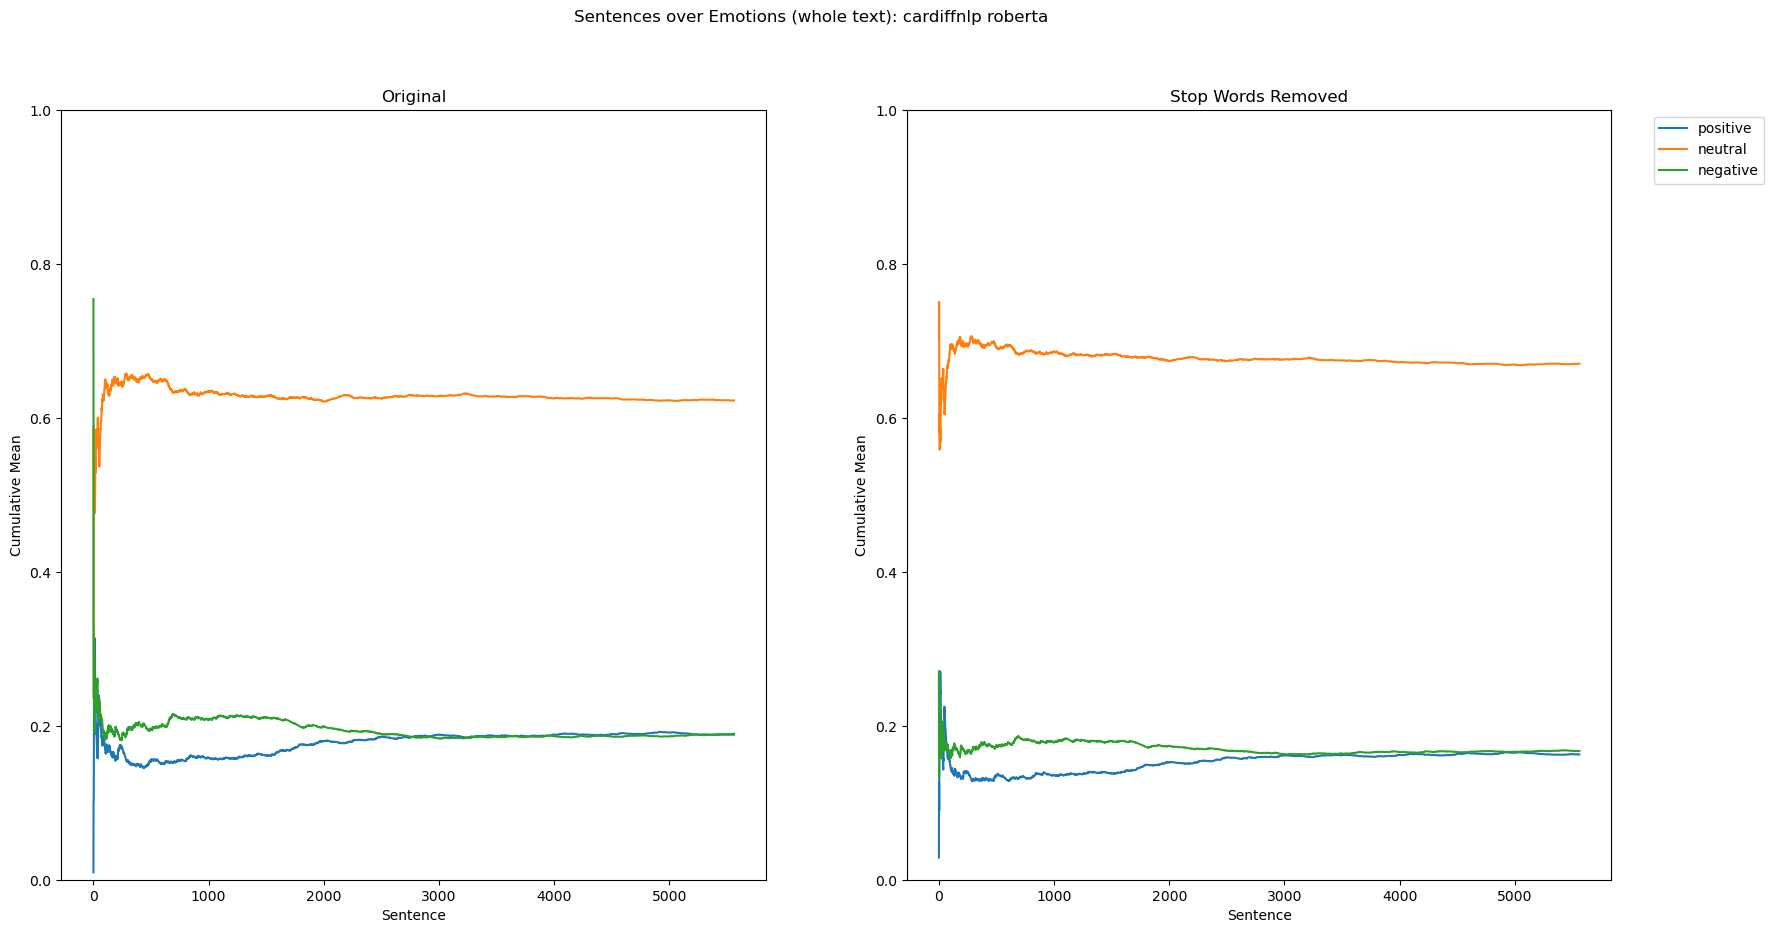

In [51]:
plot_lines(df_sentences_cm, df_stop_sentences_cm, 'Sentences over Emotions (whole text): cardiffnlp roberta')

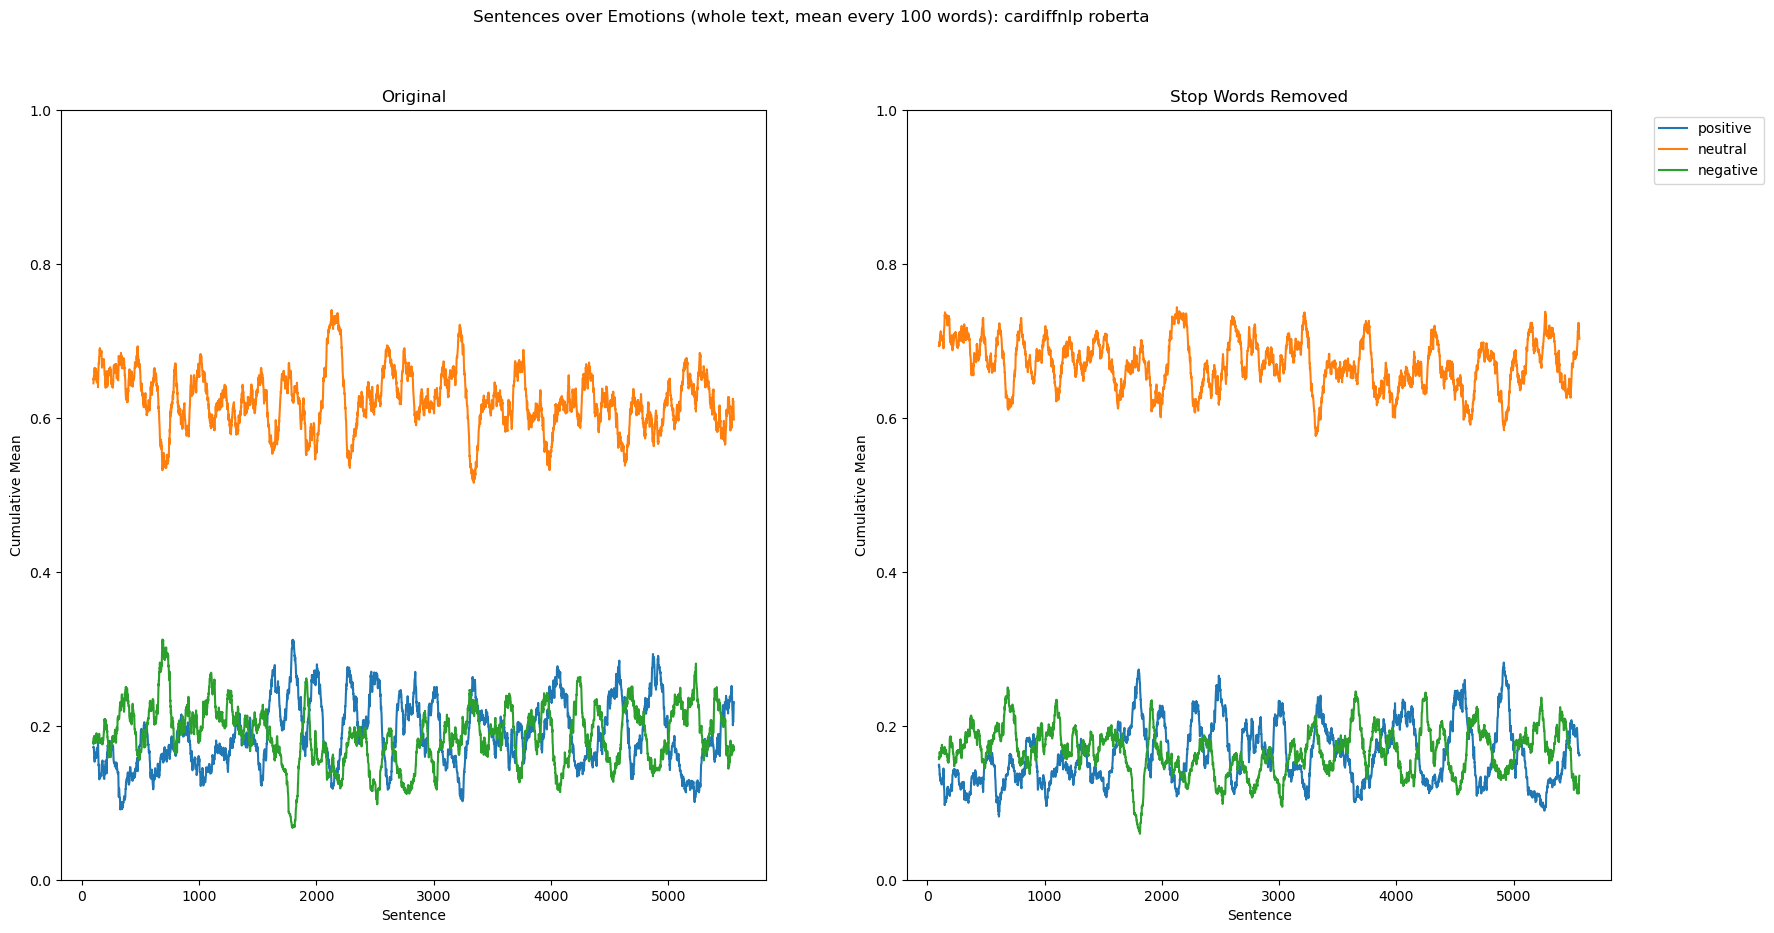

In [53]:
plot_lines(df_sentences_cm_100, df_stop_sentences_cm_100, 'Sentences over Emotions (whole text, mean every 100 words): cardiffnlp roberta')